In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [ ]:
# reading ln(D/rho^2) from figure 1 of Martian Paleoclimate (Shuster and Weiss)
y_axis_values = [-15.65, -16.40, -16.1, -16.4, -15.8, -15.38, -14.9, -14.3, -13.7, -13.3, -12.6, -11.8, -11.2, -11.0, -10.9, -10.8, -10.9, -10.8, -10.7, -10.3, -10.2, -10.1]

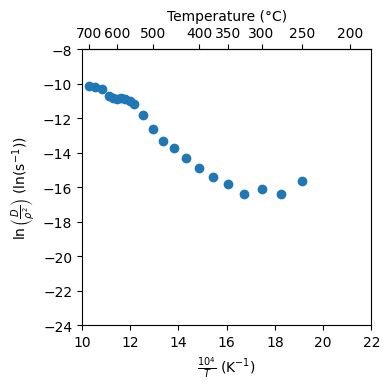

In [ ]:
df = pd.read_csv('data/nakhla1_parsed.csv')[["Temp", "39Ar", "std_39Ar", "seconds_per_extraction_step"]]
manually_fitted = [40.0, 300.0, 300.0]
y_axis_values = [-15.65, -16.40, -16.1, -16.4, -15.8, -15.38, -14.9, -14.3, -13.7, -13.3, -12.6, -11.8, -11.2, -11.0, -10.9, -10.8, -10.9, -10.8, -10.7, -10.3, -10.2, -10.1]
total_39Ar = df['39Ar'].sum()
df['ΔF'] = df['39Ar'] / total_39Ar          # fractional release per extraction step
df['F'] = df['ΔF'].cumsum()                 # cumulative release

# Fechtig & Kalbitzer (1966) piece‑wise solution for a sphere
def y_from_F(F):
    if F < 0 or F > 1:
        return np.nan
    if F < 0.85:                     # low‑loss branch: F = (6/√π)√y – 3y
        a = 6/np.sqrt(np.pi)
        disc = a*a - 12*F
        s = (a - np.sqrt(disc)) / 6          # choose the small root
        y = s**2
    else:                           # high‑loss branch: F = 1 – 6/π² e^(‑π²y)
        y = -(1/np.pi**2) * np.log((1 - F)*np.pi**2 / 6)
        # the last extraction step is invalid and accounts for >15% of the 39Ar
        # so we should never use this branch of the approximation
        raise ValueError("should never be used")
    return y

df['y'] = df['F'].apply(y_from_F)  # get dimensionless time aka "diffusion progress"
df['lnD/rho^2_true'] = y_axis_values + [np.nan] * (len(df) - len(y_axis_values))
df['seconds_per_extraction_step'] = df['y'].diff().shift(-1) / np.exp(df['lnD/rho^2_true'])
df[["Temp", "39Ar", "std_39Ar", "seconds_per_extraction_step"]].to_csv('data/nakhla1_parsed_fitted.csv')
